# Laboratory #11 : Image Segmentation using UNet

At the end of this laboratory, you would get familiarized with

*   Segmentation using UNet
*   Understand the evaluation metrics
*   Importance of data annotations

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**

---

# **Students** (First Name and Last Name)

1.   Eva Veli
2.   Tatevik Davtyan

---

# Loading dataset

*   We will use the [Tray Food Segmentation dataset](https://www.kaggle.com/thezaza102/tray-food-segmentation) for this laboratory.
*   You have two options to get the dataset into your notebook
    *   The dataset is already available in campus virtual. Upload the dataset to your drive before starting the exercise.
    *   You can use the kaggle APIs to get the dataset into the notebook directly (Advanced option).

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# Constants

*   Change the path of the directories according to your drive location.

In [ ]:
import os
import pandas as pd
import numpy as np

root_path = r'./TrayDataset/'

train_img = os.path.join(root_path, 'XTrain')
train_mask = os.path.join(root_path, 'yTrain')
test_img = os.path.join(root_path, 'XTest')
test_mask = os.path.join(root_path, 'yTest')

classes_file = os.path.join(root_path, 'classes.csv')


classes_name = pd.read_csv(classes_file)["_name"].values

*   Define the constants needed for training the model

In [ ]:
img_size = (160, 160)
num_classes = 43  # fixed for this dataset
batch_size = 32
epochs = 25

# Paths to Input Images and Segmentation Masks

*   We prepare the list of images and masks for both the train and test set

In [ ]:
import os

train_img_paths = sorted(
    [
        os.path.join(train_img, fname)
        for fname in os.listdir(train_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

train_mask_paths = sorted(
    [
        os.path.join(train_mask, fname)
        for fname in os.listdir(train_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

test_img_paths = sorted(
    [
        os.path.join(test_img, fname)
        for fname in os.listdir(test_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

test_mask_paths = sorted(
    [
        os.path.join(test_mask, fname)
        for fname in os.listdir(test_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of train samples:", len(train_img_paths))
print("Number of train masks:", len(train_mask_paths))

print("Number of test samples:", len(test_img_paths))
print("Number of test masks:", len(test_mask_paths))

Number of train samples: 1241
Number of train masks: 1241
Number of test samples: 8
Number of test masks: 8


# Visualizing input image and corresponding segmentation mask

*   Visualize one train image and the corresponding segmentation mask in a matplotlib subplot
*   Also, show the mask overlayed on the original image.

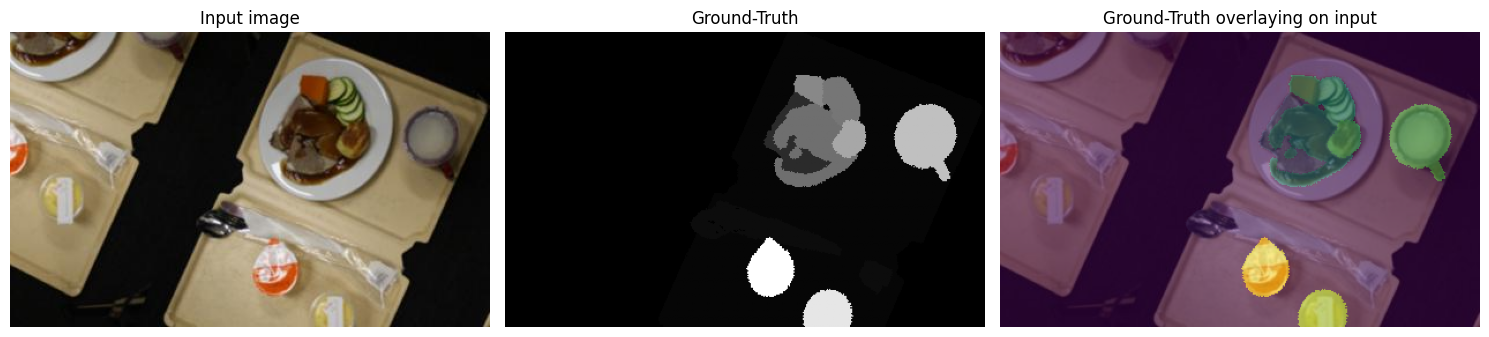

In [ ]:
# solution

from matplotlib import pyplot as plt
from PIL.ImageOps import autocontrast
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import load_img

i = 14

train_image = imread(train_img_paths[i])
ground_truth_mask = load_img(train_mask_paths[i], color_mode='grayscale')
ground_truth_autocontrast = autocontrast(ground_truth_mask)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))

for ax in axs.flatten():
    ax.axis("off")

axs[0].imshow(train_image)
axs[0].set_title("Input image")

axs[1].imshow(ground_truth_autocontrast, cmap='gray')
axs[1].set_title("Ground-Truth")

axs[2].imshow(train_image)
axs[2].imshow(ground_truth_autocontrast, alpha=0.5)
axs[2].set_title('Ground-Truth overlaying on input')

fig.tight_layout()

# Image Generator

*   Create an image generator class (similar to the tutorial) to iterate over the images and return a tuple corresponding to the batch number.
*   The generator should inherit from the Sequence class.
*   It should have \_\_init\_\_(), \_\_len\_\_() and \_\_getitem\_\_() methods.
*   The batch size, image size, image paths and mask paths should be initialized using the \_\_init\_\_ method.

In [ ]:
# solution
from tensorflow import keras
import numpy as np
from tensorflow.keras.utils import load_img
import math

class ImageGenerator(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return math.ceil(len(self.target_img_paths) / batch_size)

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

# U-Net Xception-style model

*   We will use the same model architecture that we followed in the tutorial for this exercise

In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


In [ ]:
# Free up RAM in case the model definition cells were run multiple times

keras.backend.clear_session()

In [ ]:
# Build model

model = get_model(img_size, num_classes)

*   Print the summary of the model

In [ ]:
# solution
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 80, 80, 32)           896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 80, 80, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 80, 80, 32)           0         ['batch_normalization[0][0

# Instantiate Image Generators for each split




*   For this experiment, we will use the test split as the validation generator

In [ ]:
import random

random.Random(1337).shuffle(train_img_paths)
random.Random(1337).shuffle(train_mask_paths)

# Instantiate data Sequences for each split
train_gen = ImageGenerator(batch_size, img_size, train_img_paths, train_mask_paths)

val_gen = ImageGenerator(batch_size, img_size, test_img_paths, test_mask_paths)

# Train Model

*   Configure the model for training
    *   Use 'Sparse Categorical Crossentropy' loss for training
    *   Use 'rmsprop' optimizer

In [ ]:
# solution
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy",  metrics=["accuracy"])

*   Instantiate a ModelCheckpoint callback to save only the best model



In [ ]:
# solution
callbacks = [
    keras.callbacks.ModelCheckpoint("tray_food_segmentation.h5", save_best_only=True)
]

*   Train the model using fit method

In [ ]:
# solution
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)


Epoch 1/25
39/39 [==============================] - 68s 2s/step - loss: 1.7016 - accuracy: 0.5321 - val_loss: 13.1175 - val_accuracy: 0.0035
Epoch 2/25


/Users/evaveli/Desktop/notebooks/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 71s 2s/step - loss: 0.6430 - accuracy: 0.5564 - val_loss: 9.3024 - val_accuracy: 0.0834
Epoch 3/25
39/39 [==============================] - 74s 2s/step - loss: 0.4254 - accuracy: 0.5494 - val_loss: 4.1410 - val_accuracy: 0.3427
Epoch 4/25
39/39 [==============================] - 74s 2s/step - loss: 0.3285 - accuracy: 0.5486 - val_loss: 3.0396 - val_accuracy: 0.8532
Epoch 5/25
39/39 [==============================] - 78s 2s/step - loss: 0.2675 - accuracy: 0.5489 - val_loss: 2.7113 - val_accuracy: 1.0000
Epoch 6/25
39/39 [==============================] - 79s 2s/step - loss: 0.2292 - accuracy: 0.5480 - val_loss: 2.0735 - val_accuracy: 1.0000
Epoch 7/25
39/39 [==============================] - 78s 2s/step - loss: 0.1979 - accuracy: 0.5485 - val_loss: 2.5045 - val_accuracy: 1.0000
Epoch 8/25
39/39 [==============================] - 78s 2s/step - loss: 0.1710 - accuracy: 0.5478 - val_loss: 1.3644 - val_accuracy: 1.0000
Epoch 9/25
39/39 [=============

# Visualize predictions

*   Generate predictions for all images in the validation set

In [ ]:
batch_size = 1  # we define batch_size as 1 for inferencing

val_gen = ImageGenerator(batch_size, img_size, test_img_paths, test_mask_paths)

In [ ]:
val_preds = model.predict(val_gen)

8/8 [==============================] - 1s 28ms/step


*   The mask is determined by the maximum value along the final axis. For all the predictions get the value of the predicted mask.

In [ ]:
# solution
val_pred_masks = np.argmax(val_preds, axis=-1)
print(f'Predicted masks shape: {val_pred_masks.shape}')

Predicted masks shape: (8, 160, 160)


Read the test mask images to create the ground truth

In [ ]:
# solution
from skimage.util import img_as_int

val_gts = np.array([masks_batch.squeeze(0) for _, masks_batch in val_gen]).squeeze(-1)
print(f'Ground-truth masks shape: {val_gts.shape}')

Ground-truth masks shape: (8, 160, 160)


*   For each validation image, find the jaccard similarity score

In [ ]:
from sklearn.metrics import jaccard_score

val_jaccard = [jaccard_score(gt.flatten(), pred.flatten(), average='micro')
                for gt, pred in zip(val_gts, val_pred_masks)]
print("Jaccard score:")
np.mean(val_jaccard)

Jaccard score:


0.8553476455703891

*   What do you understand from the 'average' parameter of the Jaccard similarity score function?
*   What are the different values of 'average' parameter?
*   Which parameter is used for what type of problem?

**Solution**
* The average parameter of the Jaccard is the one that indicates the type of averaging performed on the data. If None of the averages is performed we will obtain an array instead of a single value.

---

1. Micro - Calculate metrics globally by counting the total true positives, false negatives and false positives.
2. Macro - Calculates the Jaccard score for each class separately and returns their unweighted average, treating all classes equally.
3. Weighted - Computes the Jaccard score for each class and returns their average weighted by the number of true instances in each class, emphasizing larger classes.
4. Samples - Calculates the Jaccard score for each sample individually in a multi-label setting, then averages the scores across all samples.
5. Binary - Measures the Jaccard score specifically for the positive class in binary classification problems.
6. None - Returns a separate Jaccard score for each class without averaging, providing a detailed class-wise breakdown.

---
1. Micro: This is the most commonly used; it computes the average metric globally.
2. Macro: This one didn't take into account label imbalance.
3. Weighted: This alters or "corrects" the macro to account for label imbalance.
4. Samples: This one is only meaningful for mutilabel classification problems.
5. Binary: This one is used only with binary data, i.e., if targets (y_{true,pred}) are binary.

*   Randomly display one image, groundtruth mask, overlayed groundtruth mask, prediction mask, overlayed prediction mask using matplotlib

In [ ]:
from PIL.Image import fromarray

def display_image(image, ground_truth_mask, predicted_mask):
    fig, axs = plt.subplots(2, 3, figsize=(10, 8))
    for ax in axs.flatten():
        ax.axis('off')

    ground_truth_mask = fromarray(ground_truth_mask)
    ground_truth_mask = autocontrast(ground_truth_mask)

    axs[0, 0].imshow(image)
    axs[0, 1].imshow(ground_truth_mask, cmap='gray')

    axs[0, 2].imshow(image)
    axs[0, 2].imshow(ground_truth_mask, alpha=0.5)

    axs[1, 0].imshow(predicted_mask, cmap='gray')

    axs[1, 1].imshow(image)
    axs[1, 1].imshow(predicted_mask, alpha=0.5)

    axs[1, 2].imshow(ground_truth_mask)
    axs[1, 2].imshow(predicted_mask, alpha=0.5)

    axs[0, 0].set_title('Image')
    axs[0, 1].set_title('Ground-truth Mask')
    axs[0, 2].set_title('Overlayed Ground-truth')
    axs[1, 0].set_title('Predicted Mask')
    axs[1, 1].set_title('Overlayed Predicted')
    axs[1, 2].set_title('Predicted over Ground-truth')

    plt.tight_layout()
    plt.show()

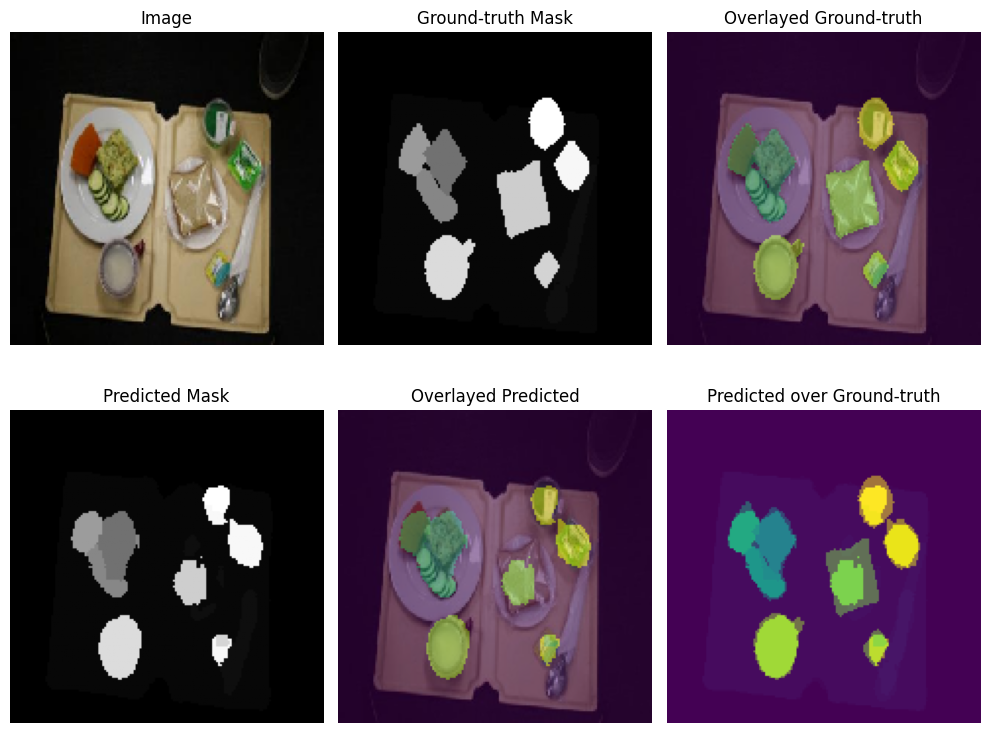

In [ ]:
# solution

num_test_images = len(test_img_paths)
random_idx = random.randint(0, num_test_images)
image = load_img(test_img_paths[random_idx], target_size=img_size)
display_image(image, val_gts[random_idx], val_pred_masks[random_idx])

*   What are other evaluation metrics to compare the performance of segmentation?

**Solution**

1. Pixel Accuracy - measures the percentage of pixels in an image that are correctly classified. It works similarly to standard accuracy metrics by determining how many pixels are correct relative to the total number of pixels. However, this method has limitations. For example, if the background occupies 90% of the image, a model can achieve 90% accuracy simply by classifying the background correctly while completely ignoring other details. This can give a misleading impression of success, especially in cases where certain parts of the image are harder to classify. This issue, known as class imbalance, requires other, more reliable metrics for evaluation.

2. Intersection-Over-Union (Jaccard Index) - focuses on comparing the predicted segmentation with the actual ground truth. It measures how much the two regions overlap compared to their combined area. Since this method considers both the prediction and the overlap, it provides a more thorough evaluation than pixel accuracy. However, IoU can be computationally expensive and complex to implement.

3. Dice Coefficient (F1 Score) - is another measure for evaluating segmentation accuracy. It assesses how well the predicted segmentation matches the ground truth by considering their overlap relative to the total pixels involved. The Dice Coefficient and IoU are closely related, often yielding similar insights. Both metrics range from 0 to 1, where 1 indicates the closest match between the prediction and the actual segmentation. If one model performs better on Dice, it typically performs similarly well on IoU.


# Testing Model in the wild

*   Download 5 images from the internet similar to the dataset used.
*   Use the trained model to segment the images

In [ ]:
def plot_images(images, predicted_masks):
    num_images = images.shape[0]

    fig, axs = plt.subplots(num_images, 3, figsize=(25, 25))
    for ax in axs.flatten():
        ax.axis('off')

    for i in range(num_images):
        image = images[i].astype('uint8')
        predicted_mask = predicted_masks[i].astype('uint8')

        axs[i, 0].imshow(image)
        axs[i, 1].imshow(predicted_mask, cmap='gray')
        axs[i, 2].imshow(image)
        axs[i, 2].imshow(predicted_mask, alpha=0.4)

        axs[i, 0].set_title('Image')
        axs[i, 1].set_title('Predicted Mask')
        axs[i, 2].set_title('Masked overlayed')

        classes = np.unique(predicted_masks[i])
        print(f'Custom image {i} classes:')
        for class_index in classes:
            print(classes_name[class_index])
        print()

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 206ms/step
Custom image 0 classes:
background
tray
cutlery
beef tomato casserole
spinach and pumpkin risotto
zucchini
sandwich
side salad
soup
milk
vanilla yogurt

Custom image 1 classes:
background
tray
cutlery
spinach and pumpkin risotto
pumpkin
orange juice

Custom image 2 classes:
background
tray
cutlery
beef tomato casserole
boiled rice
beef mexican meatballs
spinach and pumpkin risotto
zucchini
pumpkin
side salad
milk
vanilla yogurt
jelly
apple juice
orange juice
water

Custom image 3 classes:
background
tray
cutlery
beef tomato casserole
spinach and pumpkin risotto
pumpkin
side salad
milk
vanilla yogurt
lemon sponge
orange juice
water

Custom image 4 classes:
background
tray
cutlery
beef tomato casserole
spinach and pumpkin risotto
zucchini
pumpkin
soup
vanilla yogurt
orange juice
water

Custom image 5 classes:
background
tray
cutlery
beef mexican meatballs
spinach and pumpkin risotto
zucchini
pumpkin
milk
vanilla yogurt
custard
orange j

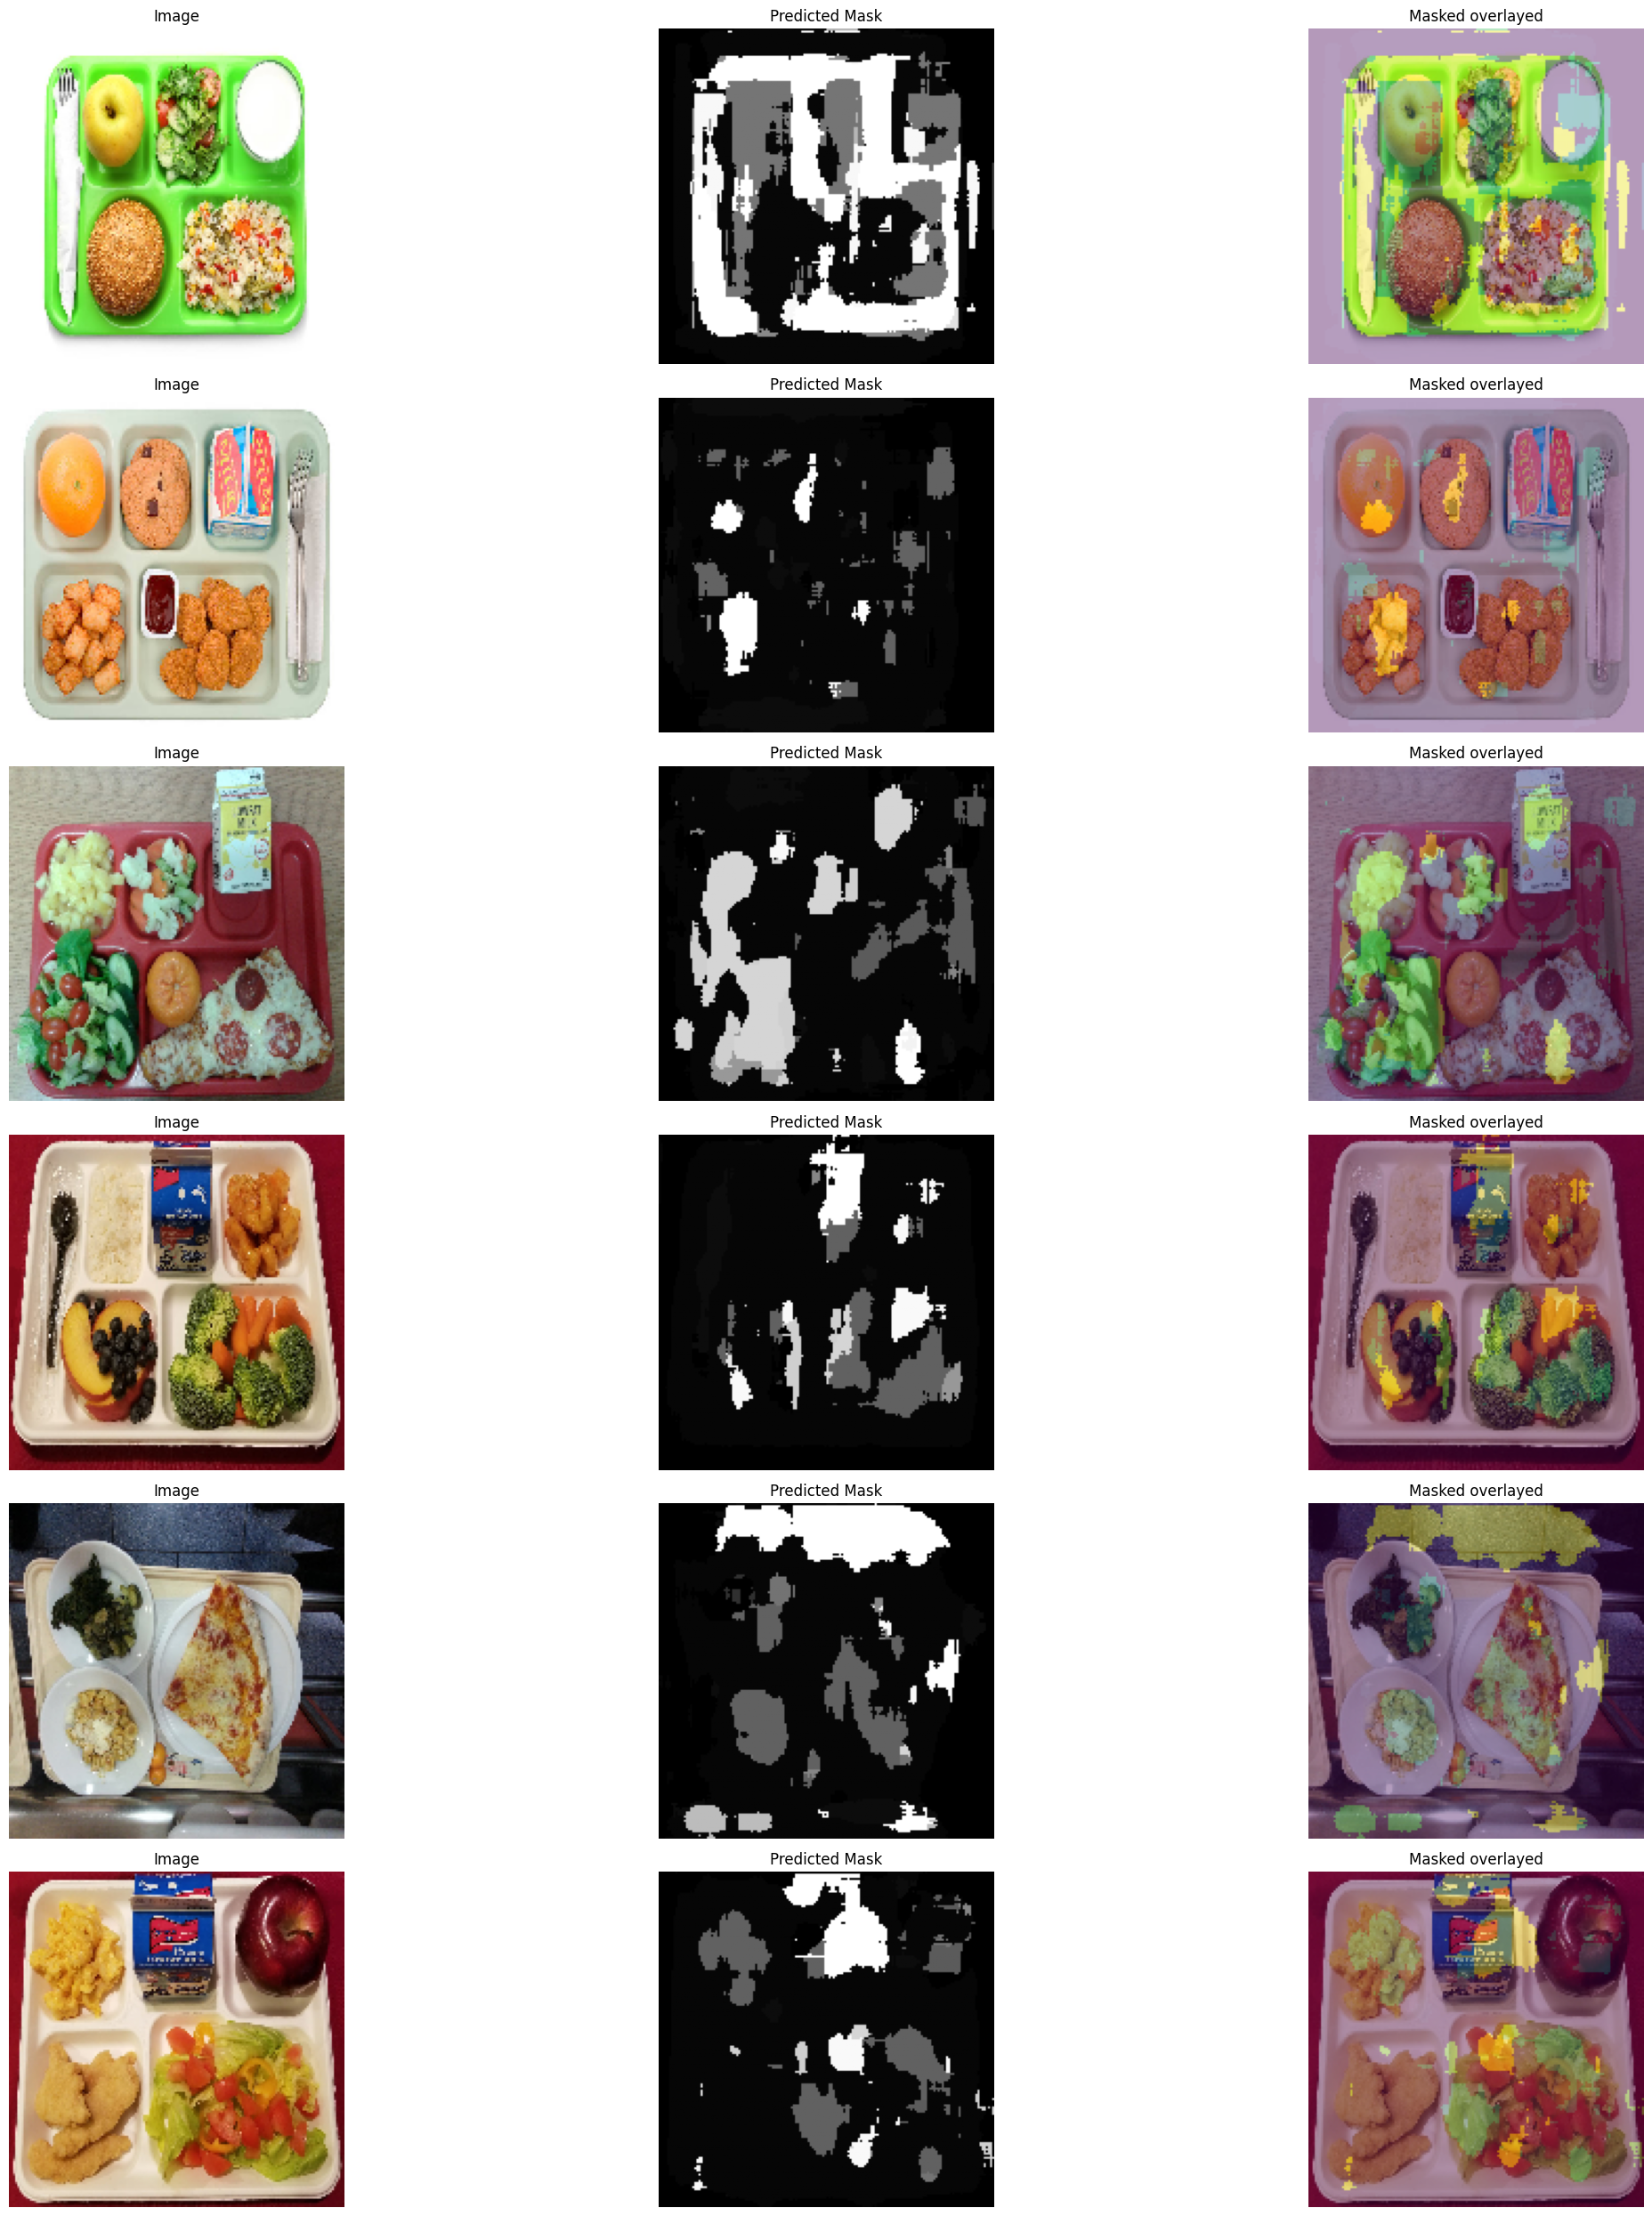

In [ ]:
# solution

custom_image_folder = f'./TestImages/'


custom_image_paths = [os.path.join(custom_image_folder, file_name) for file_name in os.listdir(custom_image_folder)]
num_custom = len(custom_image_paths)

custom_batch = np.zeros((num_custom, *img_size, 3), dtype='float32')

for i, path in enumerate(custom_image_paths):
    custom_batch[i] = load_img(path, target_size=img_size)

predictions_wild = model.predict(custom_batch)
predicted_masks_wild = np.argmax(predictions_wild, axis=-1)

plot_images(custom_batch, predicted_masks_wild)

*   How accurate are the prediction masks?
*   What happens to the unlabelled classes?

**Solution**

The model's performance decreases significantly when evaluated on validation or test images compared to the controlled training dataset. The training dataset consists of highly uniform images with a pure black background, a centrally positioned tray with consistent shape and orientation, and a fixed camera perspective. These controlled conditions differ significantly from real-world scenarios, where backgrounds may vary in color and pattern, trays may differ in shape or be partially outside the camera's field of view, and lighting conditions are less consistent. These differences lead the model to misclassify or fail to detect certain objects. For example, the model may mistake background elements for food, be misled by shadows, or fail to identify food items it was trained to recognize, such as rice in the fourth image or sandwiches.

Regarding the classes not included in the dataset, these are typically ignored and classified as part of the background (e.g., the cookie in image 2) or misclassified as food items the model has previously seen. This behavior is expected, as the model cannot classify or detect unlabeled classes it has never encountered during training. Consequently, it either misclassifies these classes or fails to detect them altogether, highlighting the need for a more diverse training dataset.






*   What are the challenges when you use a trained model in the wild?
*   How can you develop a model to be used in real world?

**Solution**

The problems mentioned in the last answer are actually the main problems that have to be taken into account when designing and training computer vision models (and machine learning models in general) that are meant to be used in real-world scenarios, in which unpredictable situations that were not present at training time may appear. Indeed, the aim of machine learning is to create models that are able to generalize from a limited set of samples, so these challenges are the core of machine learning.

However, we have seen two main kinds of problems:

* Changes in the conditions, as well as intra-class variation, prevent the model from properly dealing with classes it has been trained for. Thus, the model did not learn a general enough representation of those objects. This might be caused by a poor dataset or a "weak" model. That is why it is important to have a heterogeneous and big enough training set that allows the model to be robust to those variations. However, sometimes it is not easy or even possible to have such a dataset, and different techniques like data augmentation can be used to artificially augment the dataset and increase the generalization capacity of the model. Anyway, it is important to have representative enough validation and test sets to ensure that the model is indeed able to generalise to unseen samples and conditions.
* The model fails because of the presence of elements that were not considered in the training dataset, that is, classes of objects that were not considered during the creation of the model (like the cookie in the previous example). There are some techniques (like zero-shot learning) to enable the models to deal with these situations. Moreover, it is also useful in some domains to train the model so as to detect elements that do not match any of the previously observed classes, and even create "new" classes by clustering the "uncategorizable" elements.

...

*   What is the difference between instance segmentation and semantic segmentation?

**Solution**

Instance segmentation and semantic segmentation are both image segmentation techniques, but they serve distinct purposes. Semantic segmentation focuses on classifying each pixel in an image into a specific class, such as "car," "person," or "background," without differentiating between individual objects of the same class. For example, all cars in an image would be labeled as "car" without distinguishing between different cars. In contrast, instance segmentation goes a step further by not only classifying each pixel but also identifying and segmenting individual objects within the same class. For instance, it would label each car separately as "car 1," "car 2," and so on. While semantic segmentation provides a global understanding of the image by identifying object categories, instance segmentation adds the ability to differentiate between unique instances of objects, making it more detailed and suited for applications that require object-level analysis, such as counting or object tracking.

*   What is the difference between encoder and decoder? Should they be of the same type of neural network?

**Solution**

The primary difference between an encoder and a decoder lies in the direction in which they operate. The encoder processes the input data and converts it into an intermediate representation, while the decoder takes this intermediate state and transforms it into the output. Although encoders and decoders often work together, they can also function independently. For example, certain models may only require an encoder or a decoder.

Regarding their structure, encoders and decoders typically use the same type of neural network, but they can differ. This is because the intermediate representation generated by the encoder can be used by multiple decoders, each potentially having a distinct architecture.

In the case of UNET, it is a U-shaped encoder-decoder network consisting of four encoder blocks and four decoder blocks connected via a bridge. The encoder acts as a feature extractor, progressively learning an abstract representation of the input image through its blocks. The decoder then uses this representation to produce a semantic segmentation mask, reconstructing the output step by step.

*   What is upsampling?

**Solution**

Upsampling increases the spatial resolution of feature maps or images, often used in decoder networks for tasks like semantic segmentation and super-resolution. It restores the resolution reduced by the encoder using methods such as nearest neighbor (simple pixel copying), bilinear interpolation (smoother scaling), transposed convolutions (learnable filters), or pixel shuffle (rearranging channels into a grid). The choice of technique depends on the task, balancing simplicity, computational cost, and output quality.

...

*   What are feature channels in UNet? Why is this helpful in this architecture?

**Solution**

In UNet, feature channels represent the feature maps at each layer, capturing patterns like edges and textures. The encoder increases feature channels while reducing spatial dimensions to extract high-level features, while the decoder upsamples and reduces channels to restore spatial resolution. Skip connections link encoder and decoder layers, preserving detailed spatial information alongside abstract features. This design enables UNet to balance precision and efficiency, making it highly effective for tasks like semantic segmentation that require both spatial accuracy and semantic understanding.

...

*   What are some applications of U-Net?

**Solution**

The UNet architecture has a wide range of real-world applications, showcasing its versatility. For instance, it plays a critical role in autonomous vehicles, where semantic segmentation helps identify humans, trees, roads, and other objects, as well as detect free space, lane markings, and traffic signs. It is also extensively used in biomedical imaging, where it assists radiologists by speeding up diagnostic processes and improving accuracy. Additionally, UNet is valuable in satellite image segmentation, enabling tasks such as measuring deforestation, mapping disaster-stricken areas, and identifying looted archaeological sites. These diverse applications demonstrate UNet's adaptability across numerous fields, highlighting its importance in modern

*   What are the other popular semantic segmentation algorithms?
*   How are they different from each other?

**Solution**

There are many techniques for semantic segmentation, but two of the most popular are Fully Convolutional Networks (FCN) and Mask R-CNN.

Fully Convolutional Networks (FCN) use a combination of convolution and max-pooling layers to downsample an image, reducing its size while retaining semantic and contextual information. A class prediction is made on the reduced image, and upsampling and deconvolution layers are then applied to restore it to its original dimensions. Unlike traditional networks, FCNs do not use fully connected layers, allowing them to process images of any size. The downsampling captures high-level features, while upsampling recovers spatial details, producing an output of the same size as the input.

Mask R-CNN, on the other hand, builds on Faster R-CNN, which predicts a class label and bounding box for each object. Mask R-CNN adds a third output: a binary mask that identifies the pixels belonging to the object within the bounding box. This requires extracting a finer spatial layout of the object. To achieve this, Mask R-CNN incorporates the Fully Convolutional Network, combining it with Faster R-CNN into a unified architecture. As the current state-of-the-art for instance segmentation, Mask R-CNN excels in solving segmentation problems and is widely regarded as one of the best approaches available.

*   What are the popular semantic segmentation datasets which are available for public access?

**Solution**

* Coco Dataset: Coco is a large-scale object detection, segmentation, and captioning dataset. The dataset contains 91 classes and 80 object categories. The size of this dataset is 37.57 GB. Hence, we should be careful when training our model with this quantity of images because our model may take a lot of training time.
* PASCAL Visual Object Classes (PASCAL VOC): The Pascal dataset has 9963 images that can be classified into 20 different classes. The size of this dataset is 2 GB.
* Cityscapes Dataset: This dataset contains images of city scenes and can be used to evaluate the performance of our model in urban scenarios.

...


---

# **End of P11: Image Segmentation using UNets**

This notebook is part of **Deliverable 5**

Deadline for Deliverable 5 (P10 and P11) submission in CampusVirtual is: **Monday, the 16th of December, 2024**
